In [22]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time

In [23]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_h1y = []
data_h1z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1y.append(float(line.strip()[25:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1z.append(float(line.strip()[42:52]))
        count +=1
        
        
# convert from Bohr to angstrom
#print(np.array(data_seps)) # coordinates were recorded, not separation
# data_seps = data_seps / 0.529177

In [24]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_h2y = []
data_h2z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2y.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2z.append(float(line.strip()[42:52]))
        count +=1
        
        
# convert from Bohr to angstrom
#print(np.array(data_seps)) # coordinates were recorded, not separation
# data_seps = data_seps / 0.529177

In [25]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_oy = []
data_oz = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oy.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oz.append(float(line.strip()[42:52]))
        count +=1
        
        
# convert from Bohr to angstrom
#print(np.array(data_seps)) # coordinates were recorded, not separation
# data_seps = data_seps / 0.529177

In [26]:
bond_1 = []
bond_2 = []
side3 = []
for loc in range(0, len(data_oy)):
    bond_1.append(math.sqrt((data_oy[loc]-data_h1y[loc])**2+(data_oz[loc]-data_h1z[loc])**2))
    bond_2.append(math.sqrt((data_oy[loc]-data_h2y[loc])**2+(data_oz[loc]-data_h2z[loc])**2))
    side3.append(math.sqrt((data_h2y[loc]-data_h1y[loc])**2+(data_h2z[loc]-data_h1z[loc])**2))

In [27]:
angle = []

for location in range(0,len(data_oy)):
    angle.append(np.arccos((bond_1[location]**2+bond_2[location]**2-side3[location]**2)/(2*bond_1[location]*bond_2[location])))


In [28]:
dataset = []

for i in range (0, len(data_oy)):
    l = []
    l.append(bond_1[i])
    l.append(bond_2[i])
    l.append(angle[i])
    dataset.append(l)


In [29]:
X = dataset

In [83]:
from sklearn.cluster import KMeans
 
model = KMeans(n_clusters=30)
minsos = []
l = []
closepts = []
m = []
n = []
closest = []
closelbl = []
smallest = 9999
for i in range(50):

    model.fit(X)
    y_pred = model.predict(X)
    l = []
    m = []
    n = []
    for i in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}:
        for j in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}[i]:
            if math.sqrt((dataset[j][0]-model.cluster_centers_[i][0])**2+(dataset[j][1]-model.cluster_centers_[i][1])**2+(dataset[j][2]-model.cluster_centers_[i][2])**2) < smallest:
                smallest = math.sqrt((dataset[j][0]-model.cluster_centers_[i][0])**2+(dataset[j][1]-model.cluster_centers_[i][1])**2+(dataset[j][2]-model.cluster_centers_[i][2])**2)
                closest = dataset[j]
                closestlabel = j
        l.append(smallest)
        m.append(closest)
        n.append(closestlabel)
        smallest = 9999
    minsos.append(l)
    closepts.append(m)
    closelbl.append(n)

In [84]:
smallestsos = 9999
sos = 0
mark = 0
for i in range(len(minsos)):
    sos = 0
    for j in minsos[i]:
        sos = sos+j**2
    if sos < smallestsos:
        smallestsos = sos
        mark = i
totalset = closepts[mark]
totallbl = closelbl[mark]
print(totalset)
print(totallbl)

[[0.9661929623653812, 0.8632857254434432, 2.045182710950532], [0.8996961143855887, 0.8520106080755128, 1.874877161343255], [0.9539993695258873, 0.8987128697242076, 2.141332558077848], [0.9196100999067252, 0.8387968631576598, 2.12702226299341], [0.8289395733384061, 0.8186475698424538, 1.9587456325548271], [0.9493022919654835, 0.8200624430618046, 2.001147940562452], [0.8575169904589222, 0.8203917900886981, 2.055203958671976], [0.9515840377525157, 0.9257841760277251, 1.9616193163657067], [0.8707213651800677, 0.837465805271251, 2.1857463655412688], [0.9670107434486941, 0.9031112603314717, 2.1800723403980227], [0.9334203608520396, 0.8062440691587012, 1.8913306770651686], [0.9814311265725222, 0.9550572600201814, 2.124019852679744], [0.9480096895610298, 0.924770217739764, 2.010849140985759], [0.8726749270715362, 0.8233470925503374, 2.1271109219813655], [0.9654775192524008, 0.8475547912691817, 1.907265437005229], [0.9128299858803363, 0.8875599226090987, 2.0740893055411624], [0.9324527776929646

In [85]:
H2O_pos = '/Users/yatin/Documents/water/energies.txt'

# read and store the separations
energy = []

with open(H2O_pos, 'r') as outf:
    for line in outf:
        energy.append(float(line))

In [86]:
A = totalset
B = []
for i in totallbl:
    B.append(energy[i])
data = np.array(A)
target = np.array(B)
print(data)
print(target)

[[0.96619296 0.86328573 2.04518271]
 [0.89969611 0.85201061 1.87487716]
 [0.95399937 0.89871287 2.14133256]
 [0.9196101  0.83879686 2.12702226]
 [0.82893957 0.81864757 1.95874563]
 [0.94930229 0.82006244 2.00114794]
 [0.85751699 0.82039179 2.05520396]
 [0.95158404 0.92578418 1.96161932]
 [0.87072137 0.83746581 2.18574637]
 [0.96701074 0.90311126 2.18007234]
 [0.93342036 0.80624407 1.89133068]
 [0.98143113 0.95505726 2.12401985]
 [0.94800969 0.92477022 2.01084914]
 [0.87267493 0.82334709 2.12711092]
 [0.96547752 0.84755479 1.90726544]
 [0.91282999 0.88755992 2.07408931]
 [0.93245278 0.8194323  2.0732619 ]
 [0.98770502 0.83501194 2.19319136]
 [0.81157871 0.79441479 1.87916557]
 [0.95325409 0.80735139 1.93175688]
 [0.96961984 0.95981618 2.19753656]
 [0.88253459 0.81937758 1.96434318]
 [0.9040537  0.86861369 1.93225436]
 [0.89406213 0.84623949 2.02415944]
 [0.97711996 0.83502993 2.11910987]
 [0.94502039 0.89744568 1.89024515]
 [0.86891406 0.8116335  1.87499194]
 [0.96077755 0.89808639 2.08

(30, 3)
(30,)


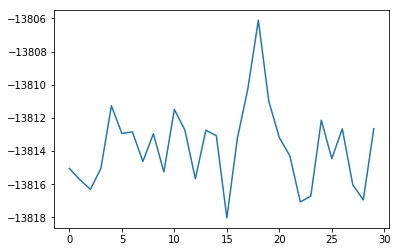

In [87]:
print(data.shape)
print(target.shape)
plt.plot(target)

 /anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


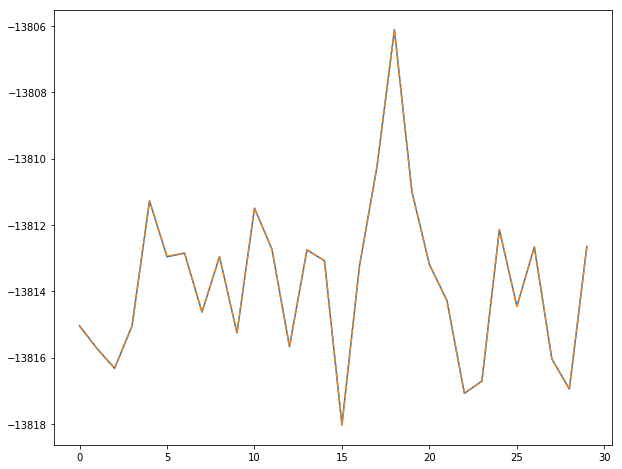

In [88]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(n_restarts_optimizer=10)
gp.fit(data, target)
target_pred, std = gp.predict(data, return_std=True)

plt.figure(figsize = (10, 8))
plt.plot(target_pred)
plt.plot(target, '--')

# References
1. 